In [1]:
from __future__ import print_function, division, absolute_import

# Gaussian Process regresstion tutorial 1:

## Introduction

In this tutorial we will create a very basic, native python GP regression code and apply it to a very simple simulated example dataset. 

* * *

By S Aigrain (University of Oxford)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from numpy.random import multivariate_normal
from numpy.linalg import inv
from numpy.linalg import slogdet
from scipy.optimize import fmin

## Problem 1: A probability distribution over functions

We saw in the lectures that a Gaussian Process enables us to set up **a probability distribution over functions**, but that probably sounds a little abstract. This problem aims to give you more of a feel for what that means, in practice.

You will start by defining a **covariance function** and using it to generate a **covariance matrix**. You will draw **samples** from the GP **prior** (i.e. draws from the probability distribution over functions, evaluated at a finite number of input locations), and then learn how to **condition** the prior on some **data**, and to draw samples from the resulting **predictive distribution**. Finally, you will explore the effect of altering the covariance matrix, specifically changing the **hyper-parameters** (the parameters of the covariance function) and the observational uncertainties.

### Problem 1a: Your first covariance function

First we need to write a function that will generate a covariance matrix for a given covariance function, or kernel. Let's start with the squared exponential kernel, which is one of the simplest and most widely used. 
$$
k_{\rm SE}(x,x') = A \exp \left[ -\Gamma (x-x')^2 \right]
$$
where $A$ is the variance and $\Gamma$ the inverse length scale. This kernel gives rise to smoothly varying, infinitely differentiable functions.

Define a function `SEKernel` that computes the covariance matrix for the above kernel function. The function should take three mandatory arguments: an array containing the hyper-parameters of the covariance function ($A$ and $\Gamma$ in the equation above), and two arrays of input values. The function should return a 2-D array with shape $(N, M)$, where $N$ and $M$ are the numbers of inputs in each of the input arrays.

*Hint: You may find the function `cdist` from the module `scipy.spatial.distance` useful, but note it expects input arrays of shape $(N,D)$ where $D$ is the number of dimensions of the inputs. 

In [8]:
def SEKernel(par, x1, x2):
    A, Gamma = par
    D2 = cdist(np.atleast_2d(x1).T, np.atleast_2d(x2).T) # complete
    return A * np.exp(-Gamma * D2**2) # complete

Generate a set of $50$ one-dimensional inputs regularly spaced between -5 and 5 and store them in a variable called `x`, then compute the covariance matrix for these inputs, for $A=\Gamma=1$, store the results in a variable called `K`, and display it using `matplotlib`'s `imshow` function.

(50, 50)


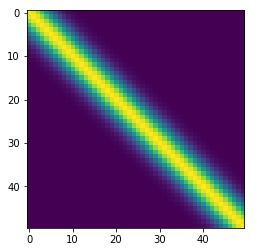

In [9]:
x = np.linspace(-5, 5, 50) # complete
K = SEKernel([1, 1], x, x) # complete
plt.imshow(K, interpolation='none');

### Problem 1b: The prior distribution: mean, confidence intervals and samples

The joint prior distribution over the outputs $\mathbf{y}$, evaluated at a given collection of inputs $\mathbf{x}$, is a multi-variate Gaussian distribution with zero mean vector and covariance matrix $K$:
$$
p(\mathbf{y}|\mathbf{x})=\mathcal(N)(\mathbf{0},K).
$$
(NB: we will consider non-zero mean functions later.) 

Plot the mean and 95% confidence interval of this distribution for the `x` and `K` evaluated in the previous cell.

*Hint: the variance $\sigma^2$ of the distribution is given by the diagonal elements of the covariance matrix, and the 95% confidence interval is bounded by the mean plus or minus 2 $\sigma$.*

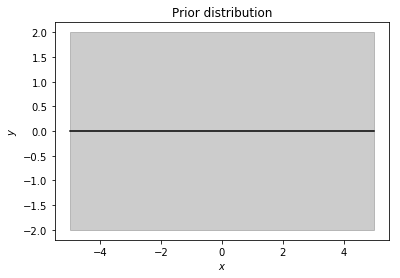

In [12]:
m = np.zeros_like(x) # complete
sig = np.diag(K)**0.5 # complete
plt.plot(x,m,'k-')
plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Prior distribution');

Now draw 5 samples from the distribution and plot them.

*Hint:* You may find the function `multivariate_normal` from the module `numpy.random` useful.

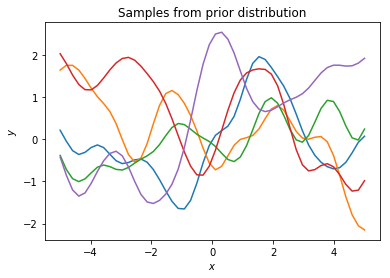

In [14]:
samples = multivariate_normal(m, K, 5) # complete
plt.plot(x,samples.T)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Samples from prior distribution');

### Problem 1c: The predictive distribution

If we have some observations $(\boldsymbol{x},\boldsymbol{y})$, only a subset of the functions included in our prior distribution will be compatible with them. As we saw in the lecture, the posterior distribution (also called the conditional or predictive distribution) for the test outputs $\boldsymbol{y}_*$, evaluated at test inputs $\boldsymbol{x}_*$, given the observations, is a multivariate Gaussian:
$$
p(\boldsymbol{y}_* \, | \, \boldsymbol{x}_*, \boldsymbol{x}, \boldsymbol{y}) = \mathcal{N}(\overline{\boldsymbol{y}}_*, \mathrm{cov}(\boldsymbol{y}_*))
$$
with mean
$$
\overline{\boldsymbol{y}}_* = K(\boldsymbol{x}_*,\boldsymbol{x}) K(\boldsymbol{x},\boldsymbol{x})^{-1} \boldsymbol{y}
$$
and covariance
$$
\mathrm{cov}(\boldsymbol{y}_*) = K(\boldsymbol{x}_*,\boldsymbol{x}_*) - K(\boldsymbol{x}_*,\boldsymbol{x}) K(\boldsymbol{x},\boldsymbol{x})^{-1} K(\boldsymbol{x},\boldsymbol{x}_*),
$$
where $K(\boldsymbol{x},\boldsymbol{x'})_{ij} = k(x_i,x'_j)$. 

If the observations are noisy, the white noise variance should be added to the diagonal of the covariance (for pairs of observed data points only).

Complete the definition of the function `Predict` below. This function computes and returns the mean and covariance of the predictive distribution for a given covariance function, with associated parameters, a given set of observations $(\mathbf{x},\mathbf{y},\mathbf{\sigma})$, where $\mathbf{\sigma}$ are the uncertainties associated with each observation, at a given set of test inputs $\mathbf{x}_*$. 

*Hint: Use `numpy`'s `dot` function to do matrix multiplication of two `numpy` arrays, or convert your arrays to `numpy` matrix objects before multiplying them together.*

*Hint: Use the `inv` function from `numpy.linalg` to invert the covariance matrix of the observations. It's not particularly stable or efficient, but code optimisation is not the point of this tutorial. In tutorial 2 we will look at some ready-made GP packages, which use much more optimized matrix inversion techniques.*

In [64]:
def Pred_GP(CovFunc, CovPar, xobs, yobs, eobs, xtest):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, xobs, xobs) # complete
    # add white noise
    K += np.identity(len(xobs)) * eobs**2 # complete
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, xtest, xtest) # complete
    # evaluate the cross-term
    Ks = CovFunc(CovPar, xtest, xobs) # complete
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = Ks @ Ki @ yobs # complete
    # evaluate the covariance
    cov = Kss - Ks @ Ki @ Ks.T # complete
    return m, cov

Execute the cell below to define a handful of observations 

In [16]:
xobs = np.array([-4,-2,0,1,2])
yobs = np.array([1.0,-1.0, -1.0, 0.7, 0.0])

Evaluate and plot the mean and 95% confidence interval of the resulting posterior distribution, as well as a few samples, for a squared exponential GP with $A=\Gamma=1$, assuming the measurement uncertainty on each observation was 0.1

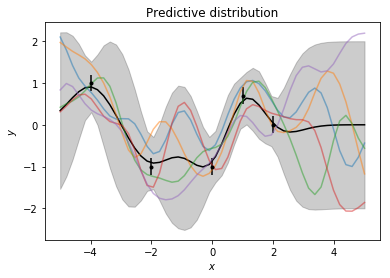

In [59]:
eobs = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
m,C=Pred_GP(SEKernel, [1, 1], xobs, yobs, eobs, x) # complete
sig = np.diag(C)**0.5 # complete
samples = multivariate_normal(m, C, 5) # complete
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.plot(x,m,'k-')
plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.2)
plt.plot(x,samples.T,alpha=0.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Predictive distribution');

Some things to note:
- while the prior distribution is stationary (the mean and variance are constant over the input range) the predictive distribution is not;
- far away grom observations, the predictive distribution returns to the prior
- where observations are close together compared to the lenght scale of the GP, the predictive ability is good: the 95% confidence interval is narrow and the samples from the predictive distribution all behave similarly
- the predictive mean doesn't have the same behaviour as the samples from the predictive distribution

### Problem 1d: Changing the hyper-parameters

Try changing the covariance function parameters $A$ and $\Gamma$ in the last cell, and then running it again. Make some notes on what happens in the cell below.

Increasing $A$ forces the result to fall closer to the points. Decreasing $\Gamma$ makes the result smoother.

So how do we know what values of the covariance parameters to use? To fit for them, we to evaluate the **likelihood** of the model. This process is known as training the GP, and is the subject of problem 2.

### Problem 1e: Changing the uncertainties

Try changing the observational uncertainties by altering the value of `eobs` in the last code cell and then running it again. Also try variable uncertainties (heteroskedastic noise) by assigning an array of $N$ values to `eobs`. Make some notes on what happens as you change the errors in the cell below.

*Hint: If you set the uncertainties to zero, you'll get an error, because the covariance matrix becomes ill-conditioned. Try setting them to a small non-zero value (e.g. $10^{-3}$) instead.*

The result falls closer to points with smaller error bars.

## Problem 2: Training the GP

In this problem we will learn how to compute the likelihood of a set of observations given a model (i.e. given a covariance function and parameters thereof) and how to optimize it relative to the hyper-parameters.

### Problem 2a: The likelihood function

Under a GP model, the likelihood is simply a multivariate Gaussian with mean vector $\mathbf{m}$ and covariance matrix $K$:
$$
p(\mathbf{y} \, | \, \mathbf{m}, K) = \mathcal{N}(\mathbf{m},K).
$$
Assuming the mean function is zero everywhere for now (we will add non-trivial mean functions later), the negative log  likelihood is then:
$$
\mathrm{NLL} = - \log p(\mathbf{y}\,|\,\mathbf{m},K) = \frac{1}{2} \mathbf{y}^{\mathrm{T}} K^{-1} \mathbf{y} + \frac{1}{2} \log |K| + \frac{N}{2} \log 2 \pi
$$
where $N$ is the number of observations.

As before, any white noise from observational uncertainties must be added to the diagonal elements of the covariance matrix.

Complete the definition of the function `NLL_GP` below. The function should evaluate the covariance matrix and return the negative log likelihood as given by the above equation. The first argument, `p`, contains the parameters of the covariance function, whose name is passed in the second argument, `CovFunc`. The remaining arguments should be self-explanatory. 

*Hint: As before, use `numpy.dot` and `numpy.linalg.inv` to do the matrix algrebra. You will also need to evaluate the log of the determinant of the covariance matrix, for this you can use `numpy.linalg.slogdet`.*

In [65]:
def NLL_GP(p,CovFunc,x,y,e):
    # Evaluate the covariance matrix
    K = CovFunc(p, x, x) # complete
    # Add the white noise term
    K += np.identity(len(e)) * e # complete
    # invert it
    Ki = inv(K)
    # evaluate each of the three terms in the NLL
    term1 = 0.5 * y.T @ Ki @ y # complete
    term2 = 0.5 * np.linalg.slogdet(K)[1] # complete
    term3 = 0.5 * len(x) * np.log(2 * np.pi) # complete
    # return the total
    return term1 + term2 + term3

Try evaluating the likelihood of the model given the observations you defined in problem 1 by executing the cell below. Hopefully it will run without errors...

In [66]:
print(NLL_GP([1, 1], SEKernel, xobs, yobs, eobs)) # complete

6.68290996773


Now try changing the covariance parameters and the observational uncertainties, and see how that affects the likelihood. Does it behave as you would expect, given the way these parameters affected the predictive distribution?

- Making $A$ too big or too small decreases the likelihood (increases the NLL), as does making $\Gamma$ too small. This is as one would expect - either the model becomes an obviously bad match, or the model uncertainty becomes huge (and that is penalised by the determinant term). 
- On the other hand, for such a sparse dataset, the likelihood asymptotes to a constant as one increases $\Gamma$ (decreases the length scale): essentially, the data doesn't contain information on the behaviour on length scales smaller than the minimum separation between observations. 

### Problem 2b: Fitting for the covariance parameters

We are now ready to find the best covariance hyper-parameters, i.e. those that minimize the NLL, for a given dataset and covariance function. 

*Hint: For simplicity we will do this using the `fmin` function from `scipy.optimize`. This is just a downhill simplex optimizer, once again it's not particularly stable or efficient, but it should do the trick for now. We will look at better ways of optimising and sampling the likelihood in Tutorial 2.*

In [ ]:
p0 = [1.0,1.0]
p1 = fmin(NLL_GP,p0,args=(# complete
print(p1)

Plot the data and the predictive distribution and samples for the best-fit hyper-parameters

In [ ]:
# You can reuse code from Problem 1c almost exactly here...

That may not have worked quite as well as you might have liked -- it's normal: the dataset we used is just too small to constrain the hyper parameters adequately. In the next problem we will tackle a slightly more realistic dataset.

## Problem 3: Modelling data with correlated noise

In this problem we will use a GP to model a simple dataset consisting of a linear trend and correlated noise, plus a small white noise component representing observational uncertainties. Our goal will be to fit for the slope of the linear trend, while  accounting for the correlated noise.

In the process, we will learn how to include a non-zero mean function in a GP model, and how to compare different covariance functions.

Execute the cell below to simulate the dataset

In [ ]:
xobs = np.linspace(-10,10,50)
linear_trend = 0.03 * xobs - 0.3
correlated_noise = multivariate_normal(np.zeros(len(xobs)),SEKernel([0.005,2.0],xobs,xobs),1).flatten()
eobs = 0.01
white_noise = np.random.normal(0,eobs,len(xobs))
yobs = linear_trend + correlated_noise + white_noise
plt.errorbar(xobs,yobs,yerr=eobs,fmt='k.',capsize=0)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

### Problem 3a: Including a mean function

This dataset contains a linear trend as well as correlated noise. We want leanr the trend at the same time as the noise, so we need to define a mean function 

Complete the definition of the mean function below, so that it evaluates abd return $f = p[0] x + p[1]$. Check that it works by plotting its output on top of the data above, taking the parameter values from the code that generated the data.

In [ ]:
def LinearMean(p,x):
    return # complete
pm0 = [0.03, -0.3]
m = # complete
plt.errorbar(xobs,yobs,yerr=eobs,fmt='k.',capsize=0)
plt.plot(xobs,m,'r-')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

### Problem 3b: Likelihood with a mean function

Evaluating the likelihood of a GP with a non-zero mean function is easy: simply evaluate the mean vector, subtract it from the data, and compute the likelihood as before, but using the residuals rather than the original data. 

Modify the likelihood function you defined earlier so that it does this. Check that it runs ok by calling it once on the dataset, using guesses for the values of the parameters.

*Hint: use optional keyword arguments so that your likelihood function still works without a mean function. You will also need to tell the likelihood function how many of the parameters belong to the mean function.*

In [ ]:
def NLL_GP2(p,CovFunc,x,y,e, MeanFunc=None, nmp = 0):
    if MeanFunc:
        pc = p[# complete
        pm = p[# complete
        r = y - # complete
    else:
        pc = p[:]
        r = y[:]
    # Evaluate the covariance matrix
    K = # complete
    # Add the white noise term
    K += # complete
    # invert it
    Ki = inv(K)
    # evaluate each of the three terms in the NLL
    term1 = # complete
    term2 = # complete
    term3 = # complete
    # return the total
    return term1 + term2 + term3

In [ ]:
p0 = [0.005,2.0,0.03,-0.3]
print(NLL_GP2# complete

Now you are ready to fit for all the hyper-parameters simultaneously: those of the covariance function, and those of the mean function. 


In [ ]:
p1 = fmin(# complete
print(p1)

**NB:** The fit can be quite sensitive to the initial guesses for the parameters. Therefore, you may find the fit converges to unexpected values unless you start fairly close to the "correct" ones. In the next tutorial, we will look at more robust ways of exploring the parameter space.

### Problem 3c: Including the mean function in the predictions

The simplest way to do this is to use the `LinearMean` function to evaluate the mean vector, and the `Pred_GP` function we wrote earlier to evaluate the stochastic component, and add the two together. 

Plot the data together with the mean and 95% confidence interval of the predictive distribution, using the best-fit hyper-parameters.

*Hint: you'll need to generate a new set of test inputs (the values at which you want to evaluate the predictive distribution) as our new dataset spans a wider range than the old one.*

In [ ]:
# Generate test inputs (values at which we ant to evaluate the predictive distribution)
x = np.linspace(# complete
# Evaluate mean function at observed inputs, and compute residuals
mobs = # complete
robs = yobs-mobs
# Evaluate stochastic component at test inputs
m,C = Pred_GP(# complete
# Evaluate mean function at test inputs
m += # complete
sig = # complete
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.plot(x,m,'k-')
plt.fill_between(x,m+2*sig,m-2*sig,color='k',alpha=0.2)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Maximum likelihood distribution');

**NB:** See how the predictive distribution continues the linear trend outside the range of hte data. If we had tried to model the same dataset without using a mean function, we might well have got a visually acceptable fit, but the predictive distribution would have returned to the prior rapidly outside the range of the data.

## Problem 4: Model comparison

One question that is frequently asked about GPs is how to chose the covariance function. There is no simple answer to this. The best starting point is domain knowledge, things you know about your dataset a priori. But if you are looking for an empirical way to compare different kernels for a given dataset, this is a standard model comparison problem.

Similarly, if you are using GPs as part of a detection problem, where you are asking whether the data contain a particular signal which is represented via the mean function, you might want to compare models with the same covariance function, but with and without a (non-zero) mean function. 

In both of the above examples, the number of hyper-parameters can vary between the models one is comparing, so model comparison is not straight forward. Ideally one would evaluate and compare the evidence for different kernels (i.e. the likelihood marginalised over the hyper-parameters), but doing this is outside the scope of the present tutorial. Therefore, here we will use a simple alternative, the Bayesian Information Criterion (BIC).

### Problem 4a: Comparing two covariance functions

Consider the dataset we simulated earlier, with the linear trend and the correlated noise. The correlated noise was generated using a squared exponential GP. If we didn't know this, would we be able to distinguish between a squared exponential and a different kind of covariance function?

To test this, let's try a changing the covariance function. We will use the Matern 3/2 kernel:
$$
k_{3/2} (x,x') = A \left[ 1 + \sqrt{3r^2} \right] \exp \left[ - \sqrt{3r^2} \right] 
$$
where $r^2=\Gamma(x-x')^2$. I picked this one for two reaons:
- This kernel gives rise to much rougher functions (which can only be differentiated once, compared to the smooth functions generated by the squared exponential kernel, which can be differentiated an infinite number of times), so in principle it should be easy to distinguish between the two kernels.
- The two kernels have the same number of parameters, so comparing the BIC's is equivalent to comparing the (maximum) likelihoods.

Start by defining a function `M32Kernel` with the same structure and calling sequence as `SEKernel`, but implementing the Matern 3/2 covariance function.

*Hint: use the `seuclidean` metric for `cdist`.*

In [ ]:
def M32Kernel(par, x1, x2):
    A, Gamma = par
    R = cdist(# complete
    return # complete

Now try fitting the data using the `LinearMean` mean function and the `M32Kernel` covariance function.

In [ ]:
p0 = [0.005,2.0,0.03,-0.3]
print(NLL_GP2(# complete
p1 = fmin(# complete
print(p1)
print(NLL_GP2(# complete

How does the best fit likelihood compare to what you obtained using the `SEKernel`? Which kernel would you adopt if you had to chose between the two. Write your answer in the cell below.

The maximum log likelihood in the case of the SEKernel was -93.25, compared to -89.55 for the `M32Kernel`, so the `SEKernel` is preferred, as one would expect, though the difference is not very large as far as these things go.

### Problem 4b: Mean, or no mean?

Now let us try comparing models with and without non-zero mean function. This time we are comparing models with different numbers of parameters, so we will need to evaluate the BIC rather than simply compare the likelihoods. The BIC is defined as:
$$
\mathrm {BIC} ={\ln(N)K-2\ln({\hat {L}})},
$$
where $N$ is the number of observations, $J$ is the number of parameters, and $\hat{L}$ refers to the likelihood maximised with respect to the parameters of the model.

Start by fitting the simulated dataset with a squared exponential kernel, with and without no mean function. Evaluate the maximum likelihood in each case and store it in variables `L_mean` and `L_no_mean`, respectively.

In [ ]:
# Copy and paste your answer to the previous problem and modify it as needed

Now evaluate the BIC in each case. Which model is preferred?

In [ ]:
N = len(xobs)
BIC_mean = # complete
print(BIC_mean)
BIC_no_mean = # complete
print(BIC_no_mean)

Thus the model with a non-zero mean function is strongly preferred (BIC differences $> 10$ are generally considered to represent very strong support for one model over the other).

How different would the predictive distributions and samples be? Try plotting them in each case.

In [ ]:
# Plot the data
plt.errorbar(xobs,yobs,yerr=2*eobs,capsize=0,fmt='k.')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title('Model comparison')
# Evaluate and plot the predictive distribution with a mean function
mobs = # complete
robs = yobs-mobs
m,C = Pred_GP(# complete
m += # complete
sig = # complete
plt.plot(x,m,'b-')
plt.fill_between(x,m+2*sig,m-2*sig,color='b',alpha=0.2)
# Now do the same for the model without mean function
m,C = Pred_GP(# complete
sig = # complete
plt.plot(x,m,'r-')
plt.fill_between(x,m+2*sig,m-2*sig,color='r',alpha=0.2)

As you can see, the predictive distribution are essentially indistinguishable in regions where we have lots of data, but the predictive ability of the model without mean function is much poorer away from the data. Of course, this is as expected.

## Challenge problem: Kepler light curve of a spotted star



In this problem you will model the light curve of a spotted star observed by Kepler using a GP with a quasi-periodic covariance function. 

[McQuillan et al. (2014)](http://iopscience.iop.org/article/10.1088/0067-0049/211/2/24/) used a method based on the auto-correlation function of the light curve to measure the rotation periods of over 30000 Kepler main-sequence stars. I have selected one, KIC2157356, which shows a very clear modulation, and for which McQuillan et al. measured a period of $13.61 \pm 0.05$ days. 

You will find one year's worth of Kepler data for this star in [this file](file/KIC2157356.txt). The 4 columns are: time in days, relative flux, flux error, and quarter number. The Kepler satellite rotates about its pointing axis every 3 months to keep its solar panels oriented towards the Sun, and this leads to breaks in the observations, as well as baseline shifts. 

Your task is to read in the data and model it using the quasi-periodic covariance function:
$$
k_{\mathrm{QP}}(t,t') = A \exp \left[ - \Gamma_1 \sin^2 \left( \frac{\pi (t-t')}{P} \right) - \Gamma_2 (t-t')^2 \right]
$$
in order to evaluate the rotation period $P$. You should start by modelling each quarter separately, checking the consistency of your results on the different quarters. 

Then introduce a mean function to account for the baseline shifts between quarters, and fit for the 4 quarters simultaneously. This will also enable you to get a better estimate of the evolutionary timescale for the star spots that cause the flux variation, which is controlled by the parameter $\Gamma_2$. 

Can you think of a way to evaluate uncertainties on the period $P$?

**NB:** This is a much bigger dataset, even when considering only a single quarter. For the GP regression to run in reasonable time, you will probably need to **sub-sample** your data.